# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

# Readme


這份作業的任務是Transfer Learning中的Domain Adversarial Training。

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 也就是左下角的那一塊。

## Scenario and Why Domain Adversarial Training
你現在有Source Data + label，其中Source Data和Target Data可能有點關係，所以你想要訓練一個model做在Source Data上並Predict在Target Data上。

但這樣有什麼樣的問題? 相信大家學過Anomaly Detection就會知道，如果有data是在Source Data沒有出現過的(或稱Abnormal的)，那麼model大部分都會因為不熟悉這個data而可能亂做一發。 

以下我們將model拆成Feature Extractor(上半部)和Classifier(下半部)來作例子:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

整個Model在學習Source Data的時候，Feature Extrator因為看過很多次Source Data，所以所抽取出來的Feature可能就頗具意義，例如像圖上的藍色Distribution，已經將圖片分成各個Cluster，所以這個時候Classifier就可以依照這個Cluster去預測結果。

但是在做Target Data的時候，Feature Extractor會沒看過這樣的Data，導致輸出的Target Feature可能不屬於在Source Feature Distribution上，這樣的Feature給Classifier預測結果顯然就不會做得好。

## Domain Adversarial Training of Nerural Networks (DaNN)
基於如此，是不是只要讓Soucre Data和Target Data經過Feature Extractor都在同個Distribution上，就會做得好了呢? 這就是DaNN的主要核心。

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

我們追加一個Domain Classifier，在學習的過程中，讓Domain Classifier去判斷經過Feature Extractor後的Feature是源自於哪個domain，讓Feature Extractor學習如何產生Feature以**騙過**Domain Classifier。 持久下來，通常Feature Extractor都會打贏Domain Classifier。(因為Domain Classifier的Input來自於Feature Extractor，而且對Feature Extractor來說Domain&Classification的任務並沒有衝突。)

如此一來，我們就可以確信不管是哪一個Domain，Feature Extractor都會把它產生在同一個Feature Distribution上。

# Data Introduce

這次的任務是Source Data: 真實照片，Target Data: 手畫塗鴉。

我們必須讓model看過真實照片以及標籤，嘗試去預測手畫塗鴉的標籤為何。

資料位於[這裡](https://drive.google.com/open?id=12-07DSquGdzN3JBHBChN4nMo3i8BqTiL)，以下的code分別為下載和觀看這次的資料大概長甚麼樣子。

特別注意一點: **這次的source和target data的圖片都是平衡的，你們可以使用這個資訊做其他事情。**

In [1]:
!nvidia-smi

Sun May 30 10:44:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Download dataset
#!gdown --id '1P4fGNb9JhJj8W0DA_Qrp7mbrRHfF5U_f' --output real_or_drawing.zip
# Unzip the files
#!unzip real_or_drawing.zip

Downloading...
From: https://drive.google.com/uc?id=1P4fGNb9JhJj8W0DA_Qrp7mbrRHfF5U_f
To: /content/real_or_drawing.zip
107MB [00:00, 205MB/s] 
Archive:  real_or_drawing.zip
replace real_or_drawing/test_data/0/00000.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace real_or_drawing/test_data/0/00001.bmp? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

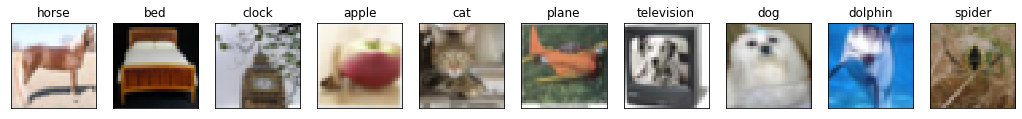

In [3]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

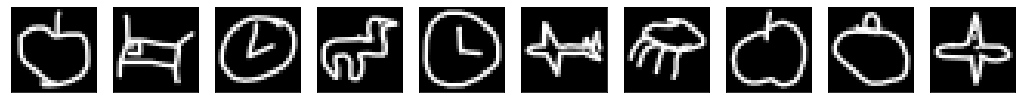

In [4]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

因為大家塗鴉的時候通常只會畫輪廓，我們可以根據這點將source data做點邊緣偵測處理，讓source data更像target data一點。

## Canny Edge Detection
算法這邊不贅述，只教大家怎麼用。若有興趣歡迎參考wiki或[這裡](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19)。

cv2.Canny使用非常方便，只需要兩個參數: low_threshold, high_threshold。

```cv2.Canny(image, low_threshold, high_threshold)```

簡單來說就是當邊緣值超過high_threshold，我們就確定它是edge。如果只有超過low_threshold，那就先判斷一下再決定是不是edge。

以下我們直接拿source data做做看。

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


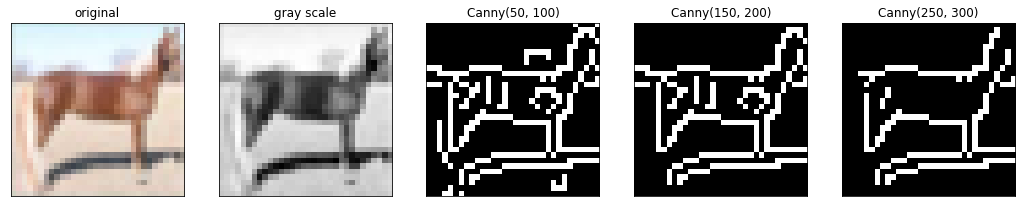

In [5]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process

在這裡我故意將data用成可以使用torchvision.ImageFolder的形式，所以只要使用該函式便可以做出一個datasets。

transform的部分請參考以下註解。
<!-- 
#### 一些細節

在一般的版本上，對灰階圖片使用RandomRotation使用```transforms.RandomRotation(15)```即可。但在colab上需要加上```fill=(0,)```才可運行。
在n98上執行需要把```fill=(0,)```拿掉才可運行。 -->


In [6]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(1116)

source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])

source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)

source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: 典型的VGG-like疊法。

Label Predictor / Domain Classifier: MLP到尾。

相信作業寫到這邊大家對以下的Layer都很熟悉，因此不再贅述。

In [7]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.ReLU(),

            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

這裡我們選用Adam來當Optimizer。

In [8]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

optimizer_F = optim.Adam(feature_extractor.parameters())
optimizer_C = optim.Adam(label_predictor.parameters())
optimizer_D = optim.Adam(domain_classifier.parameters())

# Start Training


## 如何實作DaNN?

理論上，在原始paper中是加上Gradient Reversal Layer，並將Feature Extractor / Label Predictor / Domain Classifier 一起train，但其實我們也可以交換的train Domain Classfier & Feature Extractor(就像在train GAN的Generator & Discriminator一樣)，這也是可行的。

在code實現中，我們採取後者的方式，畢竟GAN是之前的作業，應該會比較熟悉:)。

## 小提醒
* 原文中的lambda(控制Domain Adversarial Loss的係數)是有Adaptive的版本，如果有興趣可以參考[原文](https://arxiv.org/pdf/1505.07818.pdf)。
* 因為我們完全沒有target的label，所以結果如何，只好丟kaggle看看囉:)?

In [9]:
def adaptive_lambda(epoch, num_epoch):
    p = epoch / num_epoch
    return 2. / (1+np.exp(-10*p)) - 1

In [10]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

In [11]:
num_epoch = 2000

# train num_epoch
for epoch in range(num_epoch):
    # You should chooose lamnda cleverly.
    lamb = adaptive_lambda(epoch, num_epoch)
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=lamb)

    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))

epoch   0: train D loss: 0.1890, train F loss: 1.9491, acc 0.2720
epoch   1: train D loss: 0.1816, train F loss: 1.6009, acc 0.4326
epoch   2: train D loss: 0.1775, train F loss: 1.4754, acc 0.4912
epoch   3: train D loss: 0.2084, train F loss: 1.4040, acc 0.5114
epoch   4: train D loss: 0.2344, train F loss: 1.3337, acc 0.5354
epoch   5: train D loss: 0.2528, train F loss: 1.3055, acc 0.5432
epoch   6: train D loss: 0.2280, train F loss: 1.2620, acc 0.5594
epoch   7: train D loss: 0.2661, train F loss: 1.2133, acc 0.5818
epoch   8: train D loss: 0.2598, train F loss: 1.1775, acc 0.5880
epoch   9: train D loss: 0.2444, train F loss: 1.1357, acc 0.6040
epoch  10: train D loss: 0.2680, train F loss: 1.0953, acc 0.6160
epoch  11: train D loss: 0.2611, train F loss: 1.0782, acc 0.6208
epoch  12: train D loss: 0.2719, train F loss: 1.0522, acc 0.6306
epoch  13: train D loss: 0.2690, train F loss: 0.9969, acc 0.6494
epoch  14: train D loss: 0.2704, train F loss: 0.9730, acc 0.6624
epoch  15:

# Inference

就跟前幾次作業一樣。這裡我使用pd來生產csv，因為看起來比較潮(?)

此外，200 epochs的Accuracy可能會不太穩定，可以多丟幾次或train久一點。

In [12]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

In [13]:
from google.colab import files
files.download('DaNN_submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

有任何問題 Domain Adaptation 的問題可以寄信到ntu-ml-2021spring-ta@googlegroups.com。

時間允許的話我會更新在這裡。

# Special Thanks
這次的作業其實是我出在 2019FALL 的 ML Final Project，以下是我認為在 Final Report 不錯的幾組，有興趣的話歡迎大家參考看看。

[NTU_r08942071_太神啦 / 組長: 劉正仁同學](https://drive.google.com/open?id=11uNDcz7_eMS8dMQxvnWsbrdguu9k4c-c)

[NTU_r08921a08_CAT / 組長: 廖子毅同學](https://drive.google.com/open?id=1xIkSs8HAShdcfV1E0NEnf4JDbL7POZTf)
